In [126]:
# Install required packages
!pip install git+https://github.com/QC-Edu/QChem-utils.git

  Cloning https://github.com/QC-Edu/QChem-utils.git to c:\users\merni\appdata\local\temp\pip-req-build-rnz959_r
  Resolved https://github.com/QC-Edu/QChem-utils.git to commit 008bc97eef519a8005aef2724326d2f242076675
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/QC-Edu/QChem-utils.git 'C:\Users\merni\AppData\Local\Temp\pip-req-build-rnz959_r'


In [124]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants

# This gives you access to the hydrogenic wavefunctions and energies.
from qctools.hydrogen import calc_energy

In [89]:
def zeeman_energy(ml, ms, B):
    """
    Calculate the Zeeman energy in electron volts for a hydrogen atom in a magnetic field.
    
    Parameters
    ----------
    ml : int
        Magnetic quantum number.
    ms : float
        Spin quantum number.
    B : float
        Magnetic field strength in Tesla.
    
    Returns
    -------
    float
        The Zeeman energy in electron volts.
    """

    # Calculate the Bohr magneton
    mu_B = physical_constants['Bohr magneton in eV/T'][0]

    # Calculate the Zeeman energy
    E_Z = mu_B * B * (ml + 2 * ms)

    return E_Z

def strong_field_energy(n, ml, ms, B):
    """
    Calculate the energy in electron volts of a hydrogen atom in a strong magnetic field.
    
    Parameters
    ----------
    n : int
        Principal quantum number.
    ml : int
        Magnetic quantum number.
    ms : float
        Spin quantum number.
    B : float
        Magnetic field strength in Tesla.
    
    Returns
    -------
    float
        The strong-field energy in electron volts.
    """
    
    # Calculate the Zeeman energy
    E_Z = zeeman_energy(ml, ms, B)

    # Calculate the energy without the magnetic field
    E = calc_energy(n, Z=1, units='eV')

    # Calculate the energy in a strong magnetic field
    E_strong = E + E_Z

    return E_strong

In [ ]:
def energy_to_wavelength(E):
    """
    Convert energy to wavelength.
    
    Parameters
    ----------

    E : float
        Energy in electron volts.

    Returns
    -------
    float
        Wavelength in nanometers.
    """
    return 1e9 * physical_constants['Planck constant in eV s'][0] * physical_constants['speed of light in vacuum'][0] / E

def dipole_allowed_transitions(n_low, n_high):
    """
    Calculate the dipole-allowed transitions for hydrogen.
    
    Parameters
    ----------
    n_low : int
        Lower principal quantum number.
    n_high : int
        Higher principal quantum number.
    
    Returns
    -------
    transitions : dict
        A dictionary containing the allowed transitions.
    """
    # Initialize the dictonary of dipole-allowed transitions
    transitions = {}

    # Loop over all quantum numbers
    for l_high in range(0, n_high):
        for ml_high in range(-l_high, l_high+1):
            for ms_high in (-1/2, 1/2):
                for l_low in range(0, n_low):
                    for ml_low in range(-l_low, l_low+1):
                        for ms_low in (-1/2, 1/2):
                            
                            # Check if the transition is dipole-allowed by selection rules
                            if abs(l_high - l_low) == 1 and ms_high == ms_low and (ml_high == ml_low or abs(ml_high - ml_low) == 1):

                                # Add the transition to the dictionary 
                                transitions[f'{n_high}, {l_high}, {ml_high}, {ms_high} -> {n_low}, {l_low}, {ml_low}, {ms_low}'] = (n_high, l_high, ml_high, n_low, l_low, ml_low, ms_low)

    return transitions

def hydrogen_transitions(n_low, n_high, B):
    """
    Calculate the wavelengths for electronic transitions in a hydrogen atom between two energy levels.
    
    Parameters
    ----------
    n_low : int
        The lower principal quantum number.
    n_high : int
        The higher principal quantum number.
    mag_field : bool, optional
        Whether to include a magnetic field.
    mag_field_kwargs : dict, optional
        Keyword arguments for the magnetic field calculation.
    
    Returns
    -------
    wavelengths : dict
       A dictionary containing the transition wavelengths in nanometers.
    """

    # Initialize the dictonary of electronic transition wavelengths in nanometers
    wavelengths = {}

    # Compute possible transition energies if no magnetic field is present
    if B == 0:

        # Add the wavelength to the dictionary
        for n in range(n_low+1, n_high+1):
            wavelengths[f'n = {n} -> n = {n_low}'] = energy_to_wavelength(calc_energy(n, Z=1, units='eV')-calc_energy(2, Z=1, units='eV'))
    
    # Compute possible dipole-allowed transition energies if a magnetic field is present
    else:

        # Get the dipole-allowed transitions
        for n in range(n_low+1, n_high+1):  
            transitions = dipole_allowed_transitions(n_low, n)

            # Add the wavelength to the dictionary
            for transition in transitions.values():
                n_high, l_high, ml_high, n_low, l_low, ml_low, ms_low = transition
                wavelengths[f'{n_high}, {l_high}, {ml_high}, {ms_low} -> {n_low}, {l_low}, {ml_low}, {ms_low}'] = energy_to_wavelength(strong_field_energy(n_high, ml_high, ms_low, B) - strong_field_energy(n_low, ml_low, ms_low, B))

    return wavelengths

{'2, 1, -1, -0.5 -> 1, 0, 0, -0.5': 121.5022109991561,
 '2, 1, -1, 0.5 -> 1, 0, 0, 0.5': 121.5022109991561,
 '2, 1, 0, -0.5 -> 1, 0, 0, -0.5': 121.50221097158722,
 '2, 1, 0, 0.5 -> 1, 0, 0, 0.5': 121.50221097158723,
 '2, 1, 1, -0.5 -> 1, 0, 0, -0.5': 121.50221094401833,
 '2, 1, 1, 0.5 -> 1, 0, 0, 0.5': 121.50221094401834}

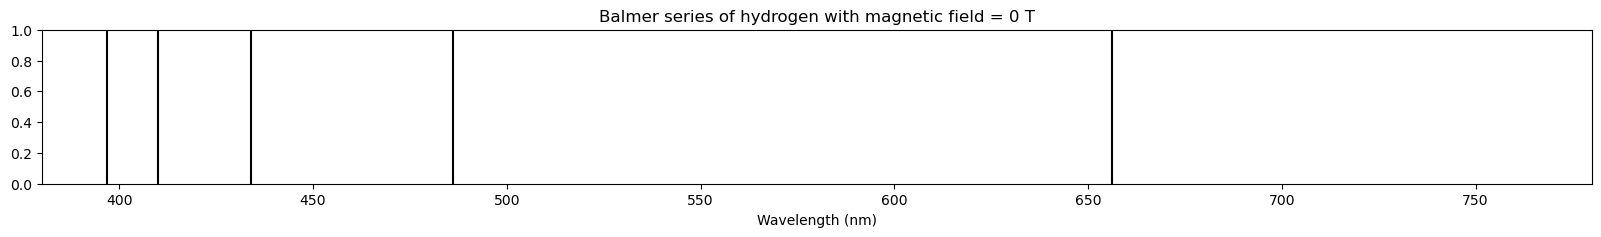

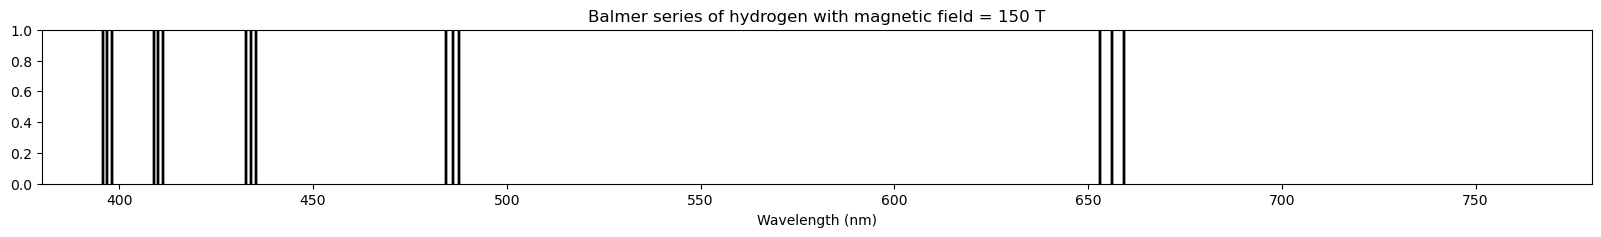

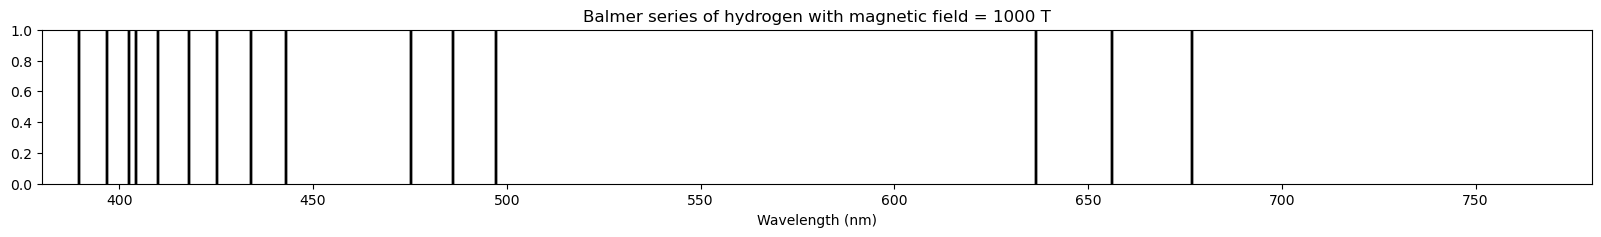

In [135]:
def balmer_series(B):
    """
    Calculate the wavelengths for the Balmer series of hydrogen.
    
    Parameters
    ----------
    n_low : int
        The lower principal quantum number.
    n_high : int
        The higher principal quantum number.
    B : float
        Magnetic field strength in Tesla.
    
    Returns
    -------
    wavelengths : dict
       A dictionary containing the transition wavelengths in nanometers.
    """
    
    # Calculate the wavelengths for the Balmer series of hydrogen
    wavelengths = hydrogen_transitions(2, 7, B).values()

    fig, axs = plt.subplots(figsize=(20, 2))
    axs.set_xlim(380, 780)
    axs.set_xlabel('Wavelength (nm)')
    axs.set_title(f'Balmer series of hydrogen with magnetic field = {B} T')

    for wavelength in wavelengths:
        plt.axvline(wavelength, color='black')

    return plt.show()

# Plot the Balmer series of hydrogen with no magnetic field.
balmer_series(0)

# Plot the Balmer series of hydrogen with a magnetic field of 150 T.
balmer_series(150)

# Plot the Balmer series of hydrogen with a magnetic field of 1000 T.
balmer_series(1000)